# Data Wrangling: Cafe Sales Dataset 

**Course:** Data Quality and Data Wrangling  
**Assignment:** Tidy Up Your Data  
**Dataset:** Augmented Dirty Cafe Sales Data  
**Date:** January 2026

---

## Table of Contents
1. [Introduction](#1-introduction)
2. [Data Loading and Initial Exploration](#2-data-loading-and-initial-exploration)
3. [Data Quality Issues Identification](#3-data-quality-issues-identification)
4. [Data Cleaning and Transformation](#4-data-cleaning-and-transformation)
5. [Data Validation](#5-data-validation)
6. [Summary and Conclusions](#6-summary-and-conclusions)

## 1. Introduction

This notebook demonstrates advanced data wrangling techniques on an augmented cafe sales dataset. The dataset contains transaction-level data with intentionally "dirty" columns that require sophisticated cleaning techniques:

- Regular Expression Extraction: For unstructured contact strings and email fields
- Pattern-based Extraction: For date and time fields in various formats
- Fuzzy Matching: To map misspelled item names to a standardized menu
- Value Imputation: Using `fillna` with default values, mean, or mode

According to Wickham (2014), tidy data follows three principles:
1. Each variable forms a column
2. Each observation forms a row
3. Each type of observational unit forms a table

We will apply these principles along with data quality management techniques to transform this "dirty" dataset into analysis-ready, tidy data.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from difflib import SequenceMatcher, get_close_matches
import warnings

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 50)
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.3.1
NumPy version: 1.26.4


## 2. Data Loading and Initial Exploration

### 2.1 Load the Dataset

In [2]:
# Load the augmented dataset
df_original = pd.read_excel('augmented_dirty_cafe_sales.xlsx')

# Create a copy for cleaning (preserving original)
df = df_original.copy()

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumns: {df.columns.tolist()}")

Dataset loaded successfully!
Shape: 10000 rows × 12 columns

Columns: ['Transaction ID', 'Item', 'Quantity', 'Price Per Unit', 'Total Spent', 'Payment Method', 'Location', 'Transaction Date', 'Customer Contact', 'Delivery ETA', 'Item (Reported)', 'Tip Amount']


### 2.2 Initial Data Inspection

In [3]:
# Display first 10 rows
print("First 10 rows of the dataset:")
df.head(10)

First 10 rows of the dataset:


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,Customer Contact,Delivery ETA,Item (Reported),Tip Amount
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08,Email: alexkhan@example.com !!!,09/08/2023 08:10 AM,café,0.49
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16,NaN,2023-05-16T11:30Z,cheesecake,0.01
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19,alexkim.84@coffeeclub.net (preferred) !!!,2023.07.20,Biscuit,0.67
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27,Phone: +1 914 632 6574,27/04/2023 14:05,salad bowl,€1.00 EUR
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11,taylormartin100@iu.org,NaN,cofee!,€0.65 GBP
5,TXN_2602893,Smoothie,5,4.0,20.0,Credit Card,NaN,2023-03-31,cameron.jones.25@example.com (preferred),ETA: 2023-03-31 07:05,sm00thie,"$1,00 GBP"
6,TXN_4433211,UNKNOWN,3,3.0,9.0,ERROR,Takeaway,2023-10-06,tel:+1 589 484 8428,10/07/2023 02:30 PM,(unknown item),12%
7,TXN_6699534,Sandwich,4,4.0,16.0,Cash,UNKNOWN,2023-10-28,Phone: 918.899.2169,2023.10.28,panini,NaN
8,TXN_4717867,NaN,5,3.0,15.0,NaN,Takeaway,2023-07-28,charliemartin.82@mail.com !!!,2023.07.28,(unknown item),0.75 (rounded)
9,TXN_2064365,Sandwich,5,4.0,20.0,NaN,In-store,2023-12-31,avery_garcia.73@mail.com,NaN,sandwich,"USD 2,41"


In [4]:
# Dataset info
print("Dataset Information:")
print("=" * 50)
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
 8   Customer Contact  9203 non-null   object
 9   Delivery ETA      7901 non-null   object
 10  Item (Reported)   10000 non-null  object
 11  Tip Amount        8991 non-null   object
dtypes: object(12)
memory usage: 937.6+ KB


In [5]:
# Basic statistics
print("\nBasic Statistics:")
print("=" * 50)
df.describe(include='all')


Basic Statistics:


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,Customer Contact,Delivery ETA,Item (Reported),Tip Amount
count,10000,9667,9862,9821,9827,7421,6735,9841,9203,7901,10000,8991
unique,10000,10,7,8,19,5,4,367,8938,6783,555,2851
top,TXN_1961373,Juice,5,3.0,6.0,Digital Wallet,Takeaway,UNKNOWN,unknown,2023-13-40 25:61,sald,—
freq,1,1171,2013,2429,979,2291,3022,159,225,70,206,240


### 2.3 Initial Data Visualization: Understanding Our Columns

Before diving into data quality issues, let's visualize each column to better understand the data structure and identify potential problems.

In [6]:
# Create a clean version for visualization (convert numeric columns)
df_viz = df.copy()

# Replace ERROR and UNKNOWN with NaN for visualization purposes
for col in df_viz.columns:
    df_viz[col] = df_viz[col].replace(['ERROR', 'UNKNOWN', ''], np.nan)

# Convert numeric columns
df_viz['Quantity'] = pd.to_numeric(df_viz['Quantity'], errors='coerce')
df_viz['Price Per Unit'] = pd.to_numeric(df_viz['Price Per Unit'], errors='coerce')
df_viz['Total Spent'] = pd.to_numeric(df_viz['Total Spent'], errors='coerce')

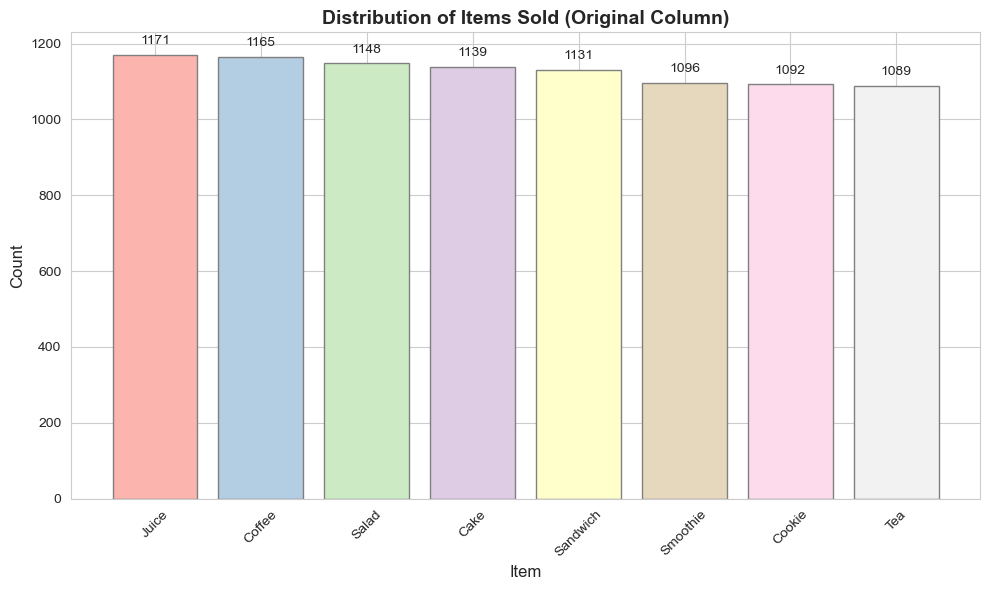


Note: 969 records have missing or invalid Item values


In [7]:
# Visualization 1: Item Distribution (Original Column)
fig, ax = plt.subplots(figsize=(10, 6))

item_counts = df_viz['Item'].value_counts()
colors = plt.cm.Pastel1(np.linspace(0, 1, len(item_counts)))
bars = ax.bar(item_counts.index, item_counts.values, color=colors, edgecolor='gray')
ax.set_xlabel('Item', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Items Sold (Original Column)', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)

for bar, count in zip(bars, item_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
            str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nNote: {df['Item'].isna().sum() + (df['Item'] == 'UNKNOWN').sum() + (df['Item'] == 'ERROR').sum()} records have missing or invalid Item values")

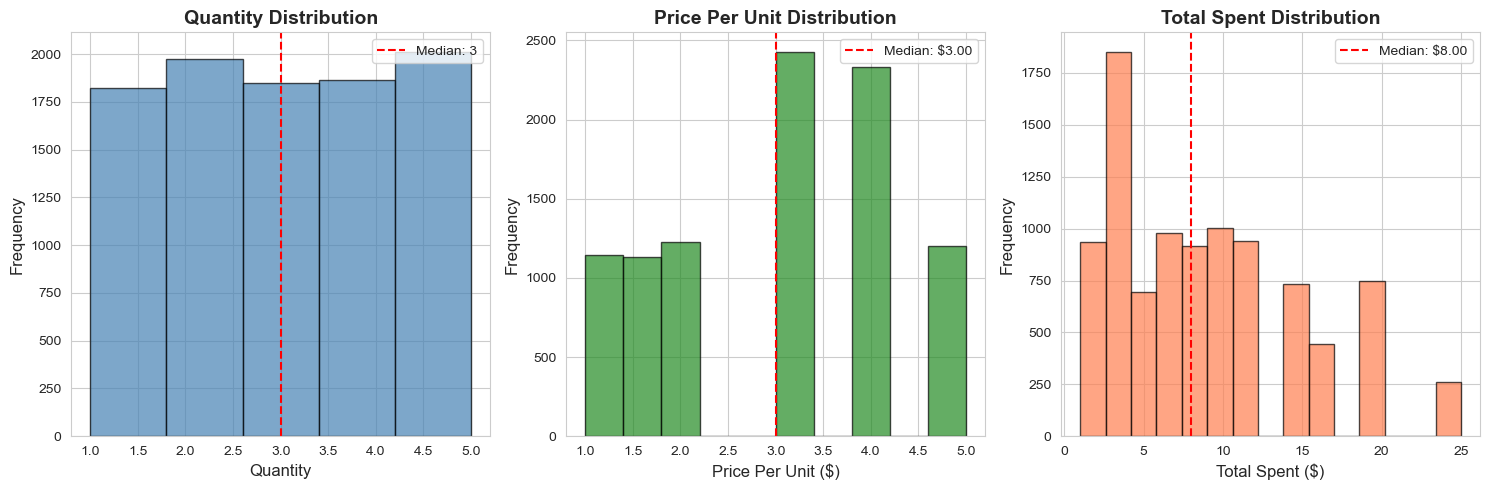

In [8]:
# Visualization 2: Numeric Columns Distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Quantity distribution
axes[0].hist(df_viz['Quantity'].dropna(), bins=5, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Quantity', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Quantity Distribution', fontsize=14, fontweight='bold')
axes[0].axvline(df_viz['Quantity'].median(), color='red', linestyle='--', label=f'Median: {df_viz["Quantity"].median():.0f}')
axes[0].legend()

# Price Per Unit distribution
axes[1].hist(df_viz['Price Per Unit'].dropna(), bins=10, color='forestgreen', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Price Per Unit ($)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Price Per Unit Distribution', fontsize=14, fontweight='bold')
axes[1].axvline(df_viz['Price Per Unit'].median(), color='red', linestyle='--', label=f'Median: ${df_viz["Price Per Unit"].median():.2f}')
axes[1].legend()

# Total Spent distribution
axes[2].hist(df_viz['Total Spent'].dropna(), bins=15, color='coral', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Total Spent ($)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Total Spent Distribution', fontsize=14, fontweight='bold')
axes[2].axvline(df_viz['Total Spent'].median(), color='red', linestyle='--', label=f'Median: ${df_viz["Total Spent"].median():.2f}')
axes[2].legend()

plt.tight_layout()
plt.show()

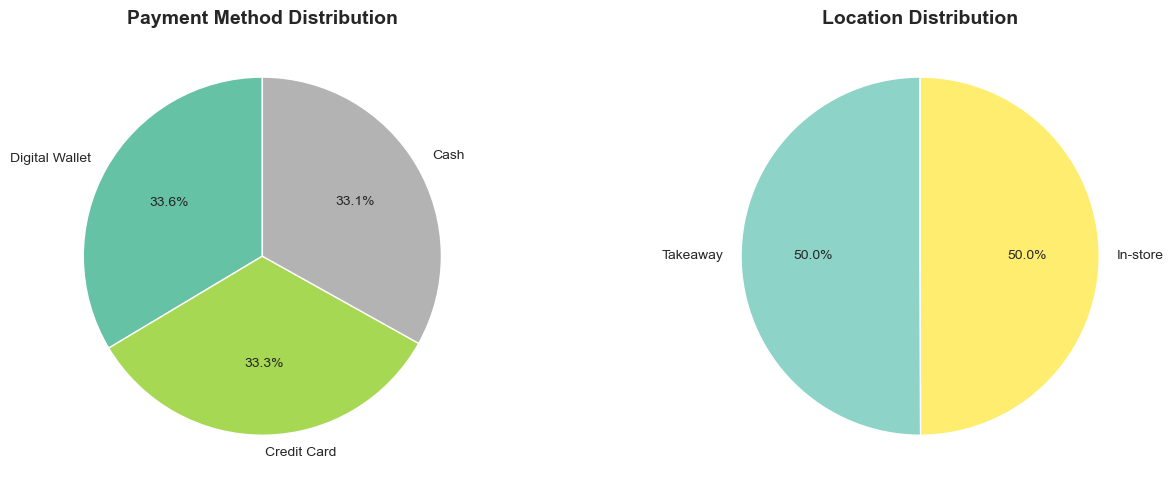

In [9]:
# Visualization 3: Payment Method and Location (Categorical)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Payment Method
payment_counts = df_viz['Payment Method'].value_counts()
colors1 = plt.cm.Set2(np.linspace(0, 1, len(payment_counts)))
axes[0].pie(payment_counts.values, labels=payment_counts.index, autopct='%1.1f%%', 
            colors=colors1, startangle=90)
axes[0].set_title('Payment Method Distribution', fontsize=14, fontweight='bold')

# Location
location_counts = df_viz['Location'].value_counts()
colors2 = plt.cm.Set3(np.linspace(0, 1, len(location_counts)))
axes[1].pie(location_counts.values, labels=location_counts.index, autopct='%1.1f%%',
            colors=colors2, startangle=90)
axes[1].set_title('Location Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

The visualizations above cover the core transactional columns. Now let's examine the remaining columns in our dataset, particularly those that contain unstructured or inconsistent data formats requiring advanced cleaning techniques.

In [10]:
# Examine Customer Contact column
print("="*70)
print("CUSTOMER CONTACT COLUMN ANALYSIS")
print("="*70)
print(f"\nMissing values: {df['Customer Contact'].isna().sum()}")
print(f"\nSample values (first 15):")
for i, val in enumerate(df['Customer Contact'].dropna().head(15)):
    print(f"  {i+1}. '{val}'")

print("\nObserved patterns:")
print("  - Emails with prefixes: 'Email:', 'contact='")
print("  - Phones with prefixes: 'Phone:', 'tel:'")
print("  - Suffixes: '!!!', '(preferred)', ';'")
print("  - Need: Regular expression extraction")

CUSTOMER CONTACT COLUMN ANALYSIS

Missing values: 797

Sample values (first 15):
  1. 'Email: alexkhan@example.com !!!'
  2. 'alexkim.84@coffeeclub.net (preferred) !!!'
  3. 'Phone: +1 914 632 6574'
  4. 'taylormartin100@iu.org'
  5. 'cameron.jones.25@example.com (preferred)'
  6. 'tel:+1 589 484 8428'
  7. 'Phone: 918.899.2169'
  8. 'charliemartin.82@mail.com !!!'
  9. ' avery_garcia.73@mail.com '
  10. ' casey_chen.72@gmail.com '
  11. ' parker.garcia@mail.com '
  12. 'charliekhan@example.com (preferred)'
  13. 'Email: riley_wright.93@gmail.com'
  14. 'contact=morgansmith@gmail.com'
  15. 'Email: cameron.chen.31@example.com'

Observed patterns:
  - Emails with prefixes: 'Email:', 'contact='
  - Phones with prefixes: 'Phone:', 'tel:'
  - Suffixes: '!!!', '(preferred)', ';'
  - Need: Regular expression extraction


In [11]:
# Examine Delivery ETA column
print("="*70)
print("DELIVERY ETA COLUMN ANALYSIS")
print("="*70)
print(f"\nMissing values: {df['Delivery ETA'].isna().sum()}")
print(f"\nSample values (first 20):")
for i, val in enumerate(df['Delivery ETA'].dropna().head(20)):
    print(f"  {i+1}. '{val}'")

print("\nObserved date formats:")
print("  - MM/DD/YYYY HH:MM AM/PM (e.g., '09/08/2023 08:10 AM')")
print("  - ISO format (e.g., '2023-05-16T11:30Z')")
print("  - YYYY.MM.DD (e.g., '2023.07.20')")
print("  - DD/MM/YYYY HH:MM (e.g., '27/04/2023 14:05')")
print("  - With prefix 'ETA:'")
print("  - Invalid dates (e.g., '2023-13-40 25:61')")
print("  - Need: Pattern-based extraction and parsing")

DELIVERY ETA COLUMN ANALYSIS

Missing values: 2099

Sample values (first 20):
  1. '09/08/2023 08:10 AM'
  2. '2023-05-16T11:30Z'
  3. '2023.07.20'
  4. '27/04/2023 14:05'
  5. 'ETA: 2023-03-31 07:05'
  6. '10/07/2023 02:30 PM'
  7. '2023.10.28'
  8. '2023.07.28'
  9. '2023.11.07'
  10. '2023.01.01'
  11. '2023-13-40 25:61'
  12. 'ETA: 16/11/2023 08:10'
  13. '2023-13-40 25:61'
  14. 'ETA: 2023.03.25'
  15. '2023.01.16'
  16. '2023-03-31T14:05Z'
  17. '2023-12-01 12:05'
  18. '18/09/2023 17:10'
  19. '2023.12.13'
  20. '11 Apr 2023 13:55'

Observed date formats:
  - MM/DD/YYYY HH:MM AM/PM (e.g., '09/08/2023 08:10 AM')
  - ISO format (e.g., '2023-05-16T11:30Z')
  - YYYY.MM.DD (e.g., '2023.07.20')
  - DD/MM/YYYY HH:MM (e.g., '27/04/2023 14:05')
  - With prefix 'ETA:'
  - Invalid dates (e.g., '2023-13-40 25:61')
  - Need: Pattern-based extraction and parsing


In [12]:
# Examine Item (Reported) column - for fuzzy matching
print("="*70)
print("ITEM (REPORTED) COLUMN ANALYSIS")
print("="*70)
print(f"\nMissing values: {df['Item (Reported)'].isna().sum()}")
print(f"\nUnique values: {df['Item (Reported)'].nunique()}")
print(f"\nSample values (first 30 unique):")
unique_items = df['Item (Reported)'].dropna().unique()[:30]
for i, val in enumerate(unique_items):
    print(f"  {i+1}. '{val}'")

print("\nObserved issues:")
print("  - Misspellings: 'cofee!', 'sm00thie', 'smothie'")
print("  - Variations: 'Biscuit' vs 'Cookie', 'panini' vs 'Sandwich'")
print("  - Whitespace: ' café ', ' sandwich '")
print("  - Unknown markers: '(unknown item)', 'Unk', '??'")
print("  - Need: Fuzzy matching to standard menu items")

ITEM (REPORTED) COLUMN ANALYSIS

Missing values: 0

Unique values: 555

Sample values (first 30 unique):
  1. ' café '
  2. 'cheesecake'
  3. 'Biscuit'
  4. 'salad bowl'
  5. 'cofee!'
  6. 'sm00thie'
  7. '(unknown item)'
  8. 'panini'
  9. ' sandwich '
  10. 'Salad Bowl'
  11. 'sand wich'
  12. 'Cookie '
  13. 'E R R O R'
  14. 'Salad'
  15. 'JUI CE'
  16. ' Cake  '
  17. 'Juice '
  18. ' smoothie '
  19. 'sandwich'
  20. 'samdwich'
  21. 'Sandwich'
  22. 'Smothie'
  23. 'biscuit'
  24. 'juce /'
  25. 'smothie'
  26. 'cupcake /'
  27. 'Unk'
  28. '??'
  29. 'Smoothie  /'
  30. 'SANDWICH'

Observed issues:
  - Misspellings: 'cofee!', 'sm00thie', 'smothie'
  - Variations: 'Biscuit' vs 'Cookie', 'panini' vs 'Sandwich'
  - Whitespace: ' café ', ' sandwich '
  - Unknown markers: '(unknown item)', 'Unk', '??'
  - Need: Fuzzy matching to standard menu items


In [13]:
# Examine Tip Amount column
print("="*70)
print("TIP AMOUNT COLUMN ANALYSIS")
print("="*70)
print(f"\nMissing values: {df['Tip Amount'].isna().sum()}")
print(f"\nSample values (first 30 unique):")
unique_tips = df['Tip Amount'].dropna().unique()[:30]
for i, val in enumerate(unique_tips):
    print(f"  {i+1}. '{val}'")

print("\nObserved patterns:")
print("  - Plain numbers: '0.49', '0.01'")
print("  - Currency symbols: '€1.00 EUR', '£0.96 USD', '$0,97 EUR'")
print("  - Percentage tips: '12%', '6%', '5%'")
print("  - Prefixed: 'tip=0.45', 'approx 0.05'")
print("  - With notes: '0.75 (rounded)'")
print("  - European decimal: '2,41' instead of '2.41'")
print("  - Invalid: '—'")
print("  - Need: String cleaning and numeric extraction")

TIP AMOUNT COLUMN ANALYSIS

Missing values: 1009

Sample values (first 30 unique):
  1. '0.49'
  2. '0.01'
  3. '0.67'
  4. '€1.00 EUR'
  5. '€0.65 GBP'
  6. '$1,00 GBP'
  7. '12%'
  8. '0.75 (rounded)'
  9. 'USD 2,41'
  10. '£0.96 USD'
  11. 'USD 0.67 USD'
  12. 'USD 0,26'
  13. '£1.51 USD'
  14. '€0.20 GBP'
  15. '$0.14 EUR'
  16. '$0,97 EUR'
  17. '6%'
  18. '0.00'
  19. 'approx 0.05'
  20. '5%'
  21. '£0.81 USD'
  22. '£0,00 USD'
  23. 'USD 0,00'
  24. '$1.21 USD'
  25. '—'
  26. '$0.01'
  27. '0.45'
  28. 'tip=0.45'
  29. '1.44 (rounded)'
  30. '10%'

Observed patterns:
  - Plain numbers: '0.49', '0.01'
  - Currency symbols: '€1.00 EUR', '£0.96 USD', '$0,97 EUR'
  - Percentage tips: '12%', '6%', '5%'
  - Prefixed: 'tip=0.45', 'approx 0.05'
  - With notes: '0.75 (rounded)'
  - European decimal: '2,41' instead of '2.41'
  - Invalid: '—'
  - Need: String cleaning and numeric extraction


## 3. Data Quality Issues Identification

Based on Wang & Strong's (1996) data quality framework, we examine:
- **Completeness**: Missing values and incomplete records
- **Accuracy**: Incorrect or inconsistent values
- **Consistency**: Data type mismatches and format issues
- **Timeliness**: Date-related issues

### 3.1 Missing Values Analysis

In [14]:
# Analyze missing values (NaN)
print("Missing Values (NaN) by Column:")
print("=" * 50)
missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Percentage': missing_pct.round(2)
})
print(missing_df)
print(f"\nTotal NaN values: {missing_counts.sum()}")

Missing Values (NaN) by Column:
                  Missing Count  Percentage
Transaction ID                0        0.00
Item                        333        3.33
Quantity                    138        1.38
Price Per Unit              179        1.79
Total Spent                 173        1.73
Payment Method             2579       25.79
Location                   3265       32.65
Transaction Date            159        1.59
Customer Contact            797        7.97
Delivery ETA               2099       20.99
Item (Reported)               0        0.00
Tip Amount                 1009       10.09

Total NaN values: 10731


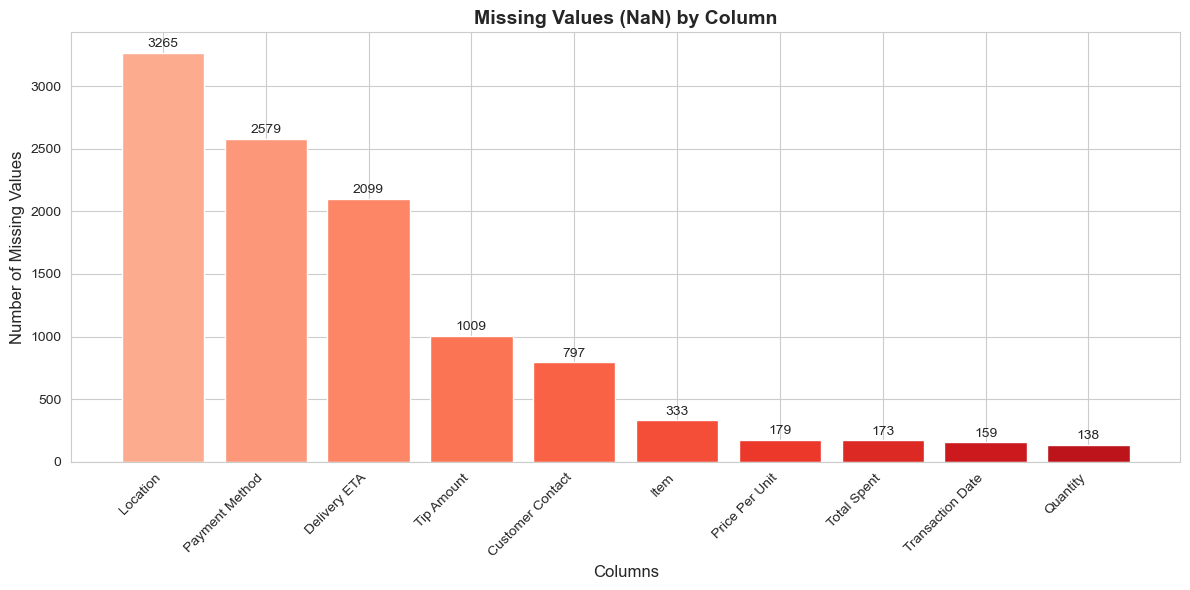

In [15]:
# Visualize missing values
plt.figure(figsize=(12, 6))
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data > 0]

if len(missing_data) > 0:
    colors = plt.cm.Reds(np.linspace(0.3, 0.8, len(missing_data)))
    bars = plt.bar(range(len(missing_data)), missing_data.values, color=colors)
    plt.xticks(range(len(missing_data)), missing_data.index, rotation=45, ha='right')
    plt.xlabel('Columns', fontsize=12)
    plt.ylabel('Number of Missing Values', fontsize=12)
    plt.title('Missing Values (NaN) by Column', fontsize=14, fontweight='bold')
    
    for bar, count in zip(bars, missing_data.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                str(count), ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in the dataset.")

### 3.2 Error Markers and Invalid Values

In [16]:
# Count ERROR and UNKNOWN markers in each column
print("ERROR and UNKNOWN Markers by Column:")
print("=" * 50)

error_unknown_counts = {}
for col in df.columns:
    error_count = (df[col].astype(str).str.upper() == 'ERROR').sum()
    unknown_count = (df[col].astype(str).str.upper() == 'UNKNOWN').sum()
    
    if error_count > 0 or unknown_count > 0:
        error_unknown_counts[col] = {
            'ERROR': error_count,
            'UNKNOWN': unknown_count
        }
        print(f"\n{col}:")
        print(f"  ERROR: {error_count}")
        print(f"  UNKNOWN: {unknown_count}")

ERROR and UNKNOWN Markers by Column:

Item:
  ERROR: 292
  UNKNOWN: 344

Quantity:
  ERROR: 170
  UNKNOWN: 171

Price Per Unit:
  ERROR: 190
  UNKNOWN: 164

Total Spent:
  ERROR: 164
  UNKNOWN: 165

Payment Method:
  ERROR: 306
  UNKNOWN: 293

Location:
  ERROR: 358
  UNKNOWN: 338

Transaction Date:
  ERROR: 142
  UNKNOWN: 159

Customer Contact:
  ERROR: 0
  UNKNOWN: 225

Delivery ETA:
  ERROR: 0
  UNKNOWN: 43

Item (Reported):
  ERROR: 56
  UNKNOWN: 116


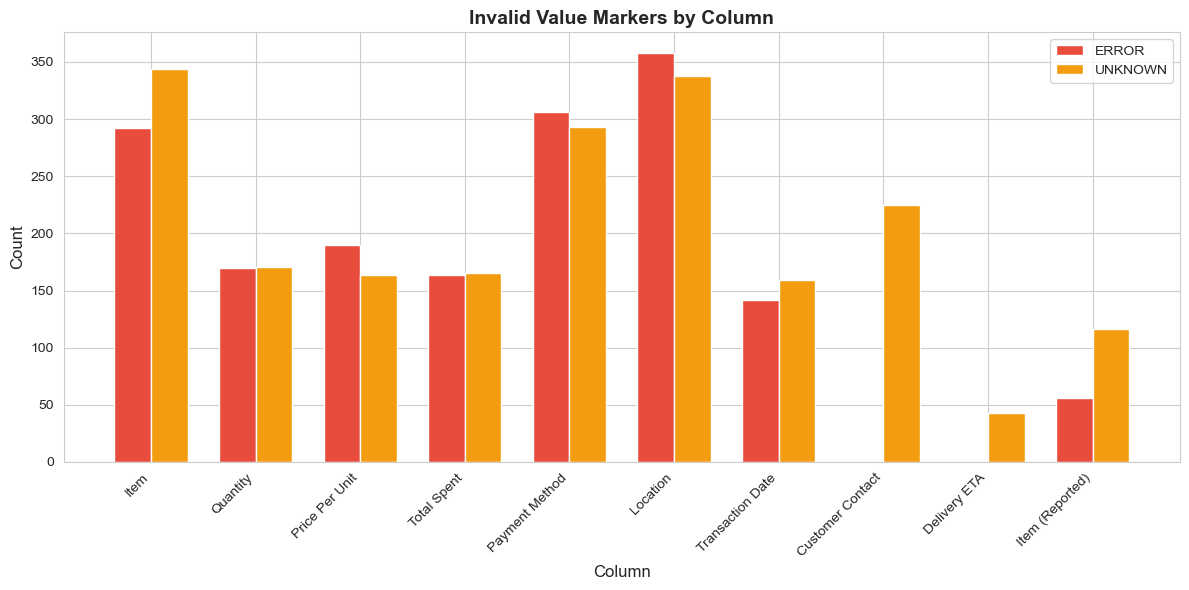

In [17]:
# Visualize ERROR and UNKNOWN markers
if error_unknown_counts:
    fig, ax = plt.subplots(figsize=(12, 6))

    cols_with_issues = list(error_unknown_counts.keys())
    error_vals = [error_unknown_counts[col]['ERROR'] for col in cols_with_issues]
    unknown_vals = [error_unknown_counts[col]['UNKNOWN'] for col in cols_with_issues]

    x = np.arange(len(cols_with_issues))
    width = 0.35

    bars1 = ax.bar(x - width/2, error_vals, width, label='ERROR', color='#e74c3c')
    bars2 = ax.bar(x + width/2, unknown_vals, width, label='UNKNOWN', color='#f39c12')

    ax.set_xlabel('Column', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Invalid Value Markers by Column', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(cols_with_issues, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

### 3.3 Data Quality Summary Report

In [18]:
# Create comprehensive summary
print("=" * 70)
print("DATA QUALITY ISSUES SUMMARY")
print("=" * 70)

total_cells = df.shape[0] * df.shape[1]
nan_count = df.isnull().sum().sum()
error_count = sum((df[col].astype(str).str.upper() == 'ERROR').sum() for col in df.columns)
unknown_count = sum((df[col].astype(str).str.upper() == 'UNKNOWN').sum() for col in df.columns)

print(f"\n1. ORIGINAL COLUMNS (8):")
print(f"   - Missing values (NaN): {nan_count}")
print(f"   - ERROR markers: {error_count}")
print(f"   - UNKNOWN markers: {unknown_count}")

print(f"\n2. NEW DIRTY COLUMNS (4):")
print(f"   - Customer Contact: Unstructured email/phone data")
print(f"   - Delivery ETA: Multiple date formats")
print(f"   - Item (Reported): Misspelled item names")
print(f"   - Tip Amount: Mixed currency formats")

print(f"\n3. CLEANING TECHNIQUES REQUIRED:")
print(f"   - Regular expressions for contact extraction")
print(f"   - Pattern matching for date parsing")
print(f"   - Fuzzy string matching for item standardization")
print(f"   - String cleaning for currency normalization")
print(f"   - Imputation with fillna for missing values")

print("\n" + "=" * 70)

DATA QUALITY ISSUES SUMMARY

1. ORIGINAL COLUMNS (8):
   - Missing values (NaN): 10731
   - ERROR markers: 1678
   - UNKNOWN markers: 2018

2. NEW DIRTY COLUMNS (4):
   - Customer Contact: Unstructured email/phone data
   - Delivery ETA: Multiple date formats
   - Item (Reported): Misspelled item names
   - Tip Amount: Mixed currency formats

3. CLEANING TECHNIQUES REQUIRED:
   - Regular expressions for contact extraction
   - Pattern matching for date parsing
   - Fuzzy string matching for item standardization
   - String cleaning for currency normalization
   - Imputation with fillna for missing values



## 4. Data Cleaning and Transformation

Following Loshin's (2011) data quality management approach and techniques from Kazil & Jarmul (2016), we will address each issue systematically.

### 4.1 Step 1: Replace ERROR and UNKNOWN Markers with NaN

In [19]:
# Create clean dataframe
df_clean = df.copy()

print("Step 1: Replacing ERROR and UNKNOWN markers with NaN")
print("=" * 60)

# Replace markers in each column
for col in df_clean.columns:
    before_count = df_clean[col].notna().sum()
    
    # Replace ERROR and UNKNOWN (case insensitive)
    df_clean[col] = df_clean[col].replace(
        to_replace=[r'^ERROR$', r'^UNKNOWN$'], 
        value=np.nan, 
        regex=True
    )
    
    after_count = df_clean[col].notna().sum()
    replaced = before_count - after_count
    
    if replaced > 0:
        print(f"{col}: Replaced {replaced} markers with NaN")

print("\nERROR and UNKNOWN markers replaced successfully!")

Step 1: Replacing ERROR and UNKNOWN markers with NaN
Item: Replaced 636 markers with NaN
Quantity: Replaced 341 markers with NaN
Price Per Unit: Replaced 354 markers with NaN
Total Spent: Replaced 329 markers with NaN
Payment Method: Replaced 599 markers with NaN
Location: Replaced 696 markers with NaN
Transaction Date: Replaced 301 markers with NaN
Item (Reported): Replaced 47 markers with NaN

ERROR and UNKNOWN markers replaced successfully!


### 4.2 Step 2: Verify Empty Strings

We check for empty strings in the dataset. If any are found, they would be converted to NaN for consistent handling.

In [20]:
print("Step 2: Checking for empty strings")
print("=" * 60)

empty_string_count = 0
for col in df_clean.columns:
    col_empty = (df_clean[col].astype(str).str.strip() == '').sum()
    empty_string_count += col_empty
    if col_empty > 0:
        df_clean[col] = df_clean[col].replace('', np.nan)
        df_clean[col] = df_clean[col].replace(' ', np.nan)
        print(f"{col}: Converted {col_empty} empty strings to NaN")

if empty_string_count == 0:
    print("No empty strings found in the dataset.")
    print("This step is not required for this particular dataset.")
else:
    print(f"\nTotal empty strings converted: {empty_string_count}")

Step 2: Checking for empty strings
No empty strings found in the dataset.
This step is not required for this particular dataset.


### 4.3 Step 3: Fix Original Numeric Data Types

In [21]:
print("Step 3: Converting original column data types\n")

# Convert numeric columns
df_clean['Quantity'] = pd.to_numeric(df_clean['Quantity'], errors='coerce')
df_clean['Price Per Unit'] = pd.to_numeric(df_clean['Price Per Unit'], errors='coerce')
df_clean['Total Spent'] = pd.to_numeric(df_clean['Total Spent'], errors='coerce')

print("Numeric columns converted:")
print(f"  Quantity: {df_clean['Quantity'].dtype}")
print(f"  Price Per Unit: {df_clean['Price Per Unit'].dtype}")
print(f"  Total Spent: {df_clean['Total Spent'].dtype}")

# Convert date column
df_clean['Transaction Date'] = pd.to_datetime(df_clean['Transaction Date'], format='%Y-%m-%d', errors='coerce')
print(f"\nTransaction Date: {df_clean['Transaction Date'].dtype}")

print("\nData types converted successfully!")

Step 3: Converting original column data types

Numeric columns converted:
  Quantity: float64
  Price Per Unit: float64
  Total Spent: float64

Transaction Date: datetime64[ns]

Data types converted successfully!


### 4.4 Step 4: Regular Expression Extraction - Customer Contact

Using regular expressions to extract clean email addresses and phone numbers from the unstructured Customer Contact field. This technique is described in Kazil & Jarmul (2016) as essential for parsing semi-structured text data.

In [22]:
print("Step 4: Extracting contact information using Regular Expressions")
print("=" * 60)

def extract_email(contact_str):
    """Extract email address from contact string using regex."""
    if pd.isna(contact_str):
        return np.nan
    
    # Email pattern: handles common email formats
    email_pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'
    match = re.search(email_pattern, str(contact_str))
    
    if match:
        return match.group(0).strip()
    return np.nan

def extract_phone(contact_str):
    """Extract phone number from contact string using regex."""
    if pd.isna(contact_str):
        return np.nan
    
    # Phone pattern: handles various formats (+1 xxx xxx xxxx, xxx.xxx.xxxx, etc.)
    phone_pattern = r'\+?1?[\s.-]?\(?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}'
    match = re.search(phone_pattern, str(contact_str))
    
    if match:
        # Clean the phone number to standard format
        phone = re.sub(r'[^\d+]', '', match.group(0))
        return phone
    return np.nan

# Apply extraction
df_clean['Contact_Email'] = df_clean['Customer Contact'].apply(extract_email)
df_clean['Contact_Phone'] = df_clean['Customer Contact'].apply(extract_phone)

# Show results
emails_extracted = df_clean['Contact_Email'].notna().sum()
phones_extracted = df_clean['Contact_Phone'].notna().sum()

print(f"\nEmails extracted: {emails_extracted}")
print(f"Phones extracted: {phones_extracted}")

print("\nSample extractions:")
sample = df_clean[['Customer Contact', 'Contact_Email', 'Contact_Phone']].dropna(subset=['Customer Contact']).head(10)
print(sample.to_string())

Step 4: Extracting contact information using Regular Expressions

Emails extracted: 5639
Phones extracted: 3311

Sample extractions:
                             Customer Contact                 Contact_Email Contact_Phone
0             Email: alexkhan@example.com !!!          alexkhan@example.com           NaN
2   alexkim.84@coffeeclub.net (preferred) !!!     alexkim.84@coffeeclub.net           NaN
3                      Phone: +1 914 632 6574                           NaN  +19146326574
4                      taylormartin100@iu.org        taylormartin100@iu.org           NaN
5    cameron.jones.25@example.com (preferred)  cameron.jones.25@example.com           NaN
6                         tel:+1 589 484 8428                           NaN  +15894848428
7                         Phone: 918.899.2169                           NaN    9188992169
8               charliemartin.82@mail.com !!!     charliemartin.82@mail.com           NaN
9                   avery_garcia.73@mail.com       avery_

### 4.5 Step 5: Pattern-Based Date Extraction - Delivery ETA

The Delivery ETA column contains dates in multiple formats. We use pattern matching and the `dateutil` parser concept to handle various date formats.

In [23]:
print("Step 5: Parsing Delivery ETA dates using pattern matching")
print("=" * 60)

def parse_delivery_eta(eta_str):
    """Parse delivery ETA from various date formats."""
    if pd.isna(eta_str):
        return np.nan
    
    eta_str = str(eta_str).strip()
    
    # Remove common prefixes
    eta_str = re.sub(r'^ETA:\s*', '', eta_str, flags=re.IGNORECASE)
    
    # List of date formats to try
    date_formats = [
        '%Y-%m-%dT%H:%MZ',      # ISO format: 2023-05-16T11:30Z
        '%Y-%m-%d %H:%M',       # 2023-12-01 12:05
        '%Y-%m-%d',             # 2023-05-16
        '%Y.%m.%d',             # 2023.07.20
        '%m/%d/%Y %I:%M %p',    # 09/08/2023 08:10 AM
        '%m/%d/%Y %H:%M',       # 10/07/2023 02:30
        '%d/%m/%Y %H:%M',       # 27/04/2023 14:05
        '%d/%m/%Y',             # 27/04/2023
        '%d %b %Y %H:%M',       # 11 Apr 2023 13:55
        '%d %B %Y %H:%M',       # 11 April 2023 13:55
    ]
    
    for fmt in date_formats:
        try:
            parsed_date = datetime.strptime(eta_str, fmt)
            return parsed_date
        except ValueError:
            continue
    
    # If no format matched, return NaN (invalid date)
    return np.nan

# Apply parsing
df_clean['Delivery_Date_Parsed'] = df_clean['Delivery ETA'].apply(parse_delivery_eta)

# Convert to datetime
df_clean['Delivery_Date_Parsed'] = pd.to_datetime(df_clean['Delivery_Date_Parsed'], errors='coerce')

# Count results
total_eta = df_clean['Delivery ETA'].notna().sum()
parsed_successfully = df_clean['Delivery_Date_Parsed'].notna().sum()
failed_parsing = total_eta - parsed_successfully

print(f"\nTotal ETA values: {total_eta}")
print(f"Successfully parsed: {parsed_successfully}")
print(f"Failed to parse (invalid dates): {failed_parsing}")

print("\nSample parsed dates:")
sample = df_clean[['Delivery ETA', 'Delivery_Date_Parsed']].dropna(subset=['Delivery ETA']).head(10)
print(sample.to_string())

Step 5: Parsing Delivery ETA dates using pattern matching

Total ETA values: 7901
Successfully parsed: 7670
Failed to parse (invalid dates): 231

Sample parsed dates:
             Delivery ETA Delivery_Date_Parsed
0     09/08/2023 08:10 AM  2023-09-08 08:10:00
1       2023-05-16T11:30Z  2023-05-16 11:30:00
2              2023.07.20  2023-07-20 00:00:00
3        27/04/2023 14:05  2023-04-27 14:05:00
5   ETA: 2023-03-31 07:05  2023-03-31 07:05:00
6     10/07/2023 02:30 PM  2023-10-07 14:30:00
7              2023.10.28  2023-10-28 00:00:00
8              2023.07.28  2023-07-28 00:00:00
10             2023.11.07  2023-11-07 00:00:00
11             2023.01.01  2023-01-01 00:00:00


### 4.6 Step 6: Fuzzy Matching - Item (Reported)

The Item (Reported) column contains misspelled item names. We use fuzzy string matching (via `difflib.SequenceMatcher`) to map these to the standard menu items. This technique is essential for handling user-generated data where typos are common (Kazil & Jarmul, 2016).

In [24]:
print("Step 6: Applying Fuzzy Matching to standardize item names")
print("=" * 60)

# Define the standard menu items (from the original Item column)
STANDARD_MENU = ['Coffee', 'Tea', 'Juice', 'Smoothie', 'Cookie', 'Cake', 'Sandwich', 'Salad']

# Define known mappings for common variations
KNOWN_MAPPINGS = {
    # Coffee variations
    'café': 'Coffee', 'cafe': 'Coffee', 'cofee': 'Coffee', 'coffe': 'Coffee',
    'c0ffee': 'Coffee', 'koffee': 'Coffee', 'caf': 'Coffee',
    # Tea variations
    'tee': 'Tea', 't e a': 'Tea',
    # Juice variations  
    'juce': 'Juice', 'juic': 'Juice', 'jui ce': 'Juice',
    # Smoothie variations
    'sm00thie': 'Smoothie', 'smothie': 'Smoothie', 'smoothe': 'Smoothie',
    'smoothy': 'Smoothie',
    # Cookie variations
    'biscuit': 'Cookie', 'cookies': 'Cookie', 'cooky': 'Cookie', 'cokie': 'Cookie',
    # Cake variations
    'cheesecake': 'Cake', 'cupcake': 'Cake', 'cak': 'Cake',
    # Sandwich variations
    'panini': 'Sandwich', 'sand wich': 'Sandwich', 'samdwich': 'Sandwich',
    'sandwch': 'Sandwich', 'sub': 'Sandwich',
    # Salad variations
    'salad bowl': 'Salad', 'sald': 'Salad', 'salat': 'Salad',
    # Unknown markers
    '(unknown item)': np.nan, 'unknown item': np.nan, 'unk': np.nan, 
    '??': np.nan, 'item_error': np.nan, 'e r r o r': np.nan,
}

def normalize_text(text):
    """Normalize accented characters to ASCII equivalents."""
    replacements = {
        'é': 'e', 'è': 'e', 'ê': 'e', 'ë': 'e',
        'á': 'a', 'à': 'a', 'â': 'a', 'ä': 'a',
        'í': 'i', 'ì': 'i', 'î': 'i', 'ï': 'i',
        'ó': 'o', 'ò': 'o', 'ô': 'o', 'ö': 'o',
        'ú': 'u', 'ù': 'u', 'û': 'u', 'ü': 'u',
        'ñ': 'n', 'ç': 'c'
    }
    for accented, normal in replacements.items():
        text = text.replace(accented, normal)
    return text

def fuzzy_match_item(reported_item):
    """Match a reported item name to the standard menu using fuzzy matching."""
    if pd.isna(reported_item):
        return np.nan
    
    # Clean the input: lowercase, strip, normalize accents
    cleaned = str(reported_item).lower().strip()
    cleaned = normalize_text(cleaned)  # Handle accented characters
    cleaned = re.sub(r'[^a-z0-9\s]', '', cleaned)  # Remove special chars
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()  # Normalize whitespace
    
    # Check known mappings first (also normalize the keys)
    for key, value in KNOWN_MAPPINGS.items():
        normalized_key = normalize_text(key.lower())
        if cleaned == normalized_key or normalized_key in cleaned:
            return value
    
    # Try exact match (case-insensitive)
    for item in STANDARD_MENU:
        if cleaned == item.lower():
            return item
    
    # Use fuzzy matching with SequenceMatcher
    best_match = None
    best_ratio = 0.0
    
    for item in STANDARD_MENU:
        ratio = SequenceMatcher(None, cleaned, item.lower()).ratio()
        if ratio > best_ratio:
            best_ratio = ratio
            best_match = item
    
    # Only accept matches with similarity >= 0.6 (60%)
    if best_ratio >= 0.6:
        return best_match
    
    # No good match found
    return np.nan

# Apply fuzzy matching
df_clean['Item_Standardized'] = df_clean['Item (Reported)'].apply(fuzzy_match_item)

# Show results
total_reported = df_clean['Item (Reported)'].notna().sum()
matched_successfully = df_clean['Item_Standardized'].notna().sum()

print(f"\nTotal reported items: {total_reported}")
print(f"Successfully matched: {matched_successfully}")
print(f"Could not match: {total_reported - matched_successfully}")

print("\nStandardized item distribution:")
print(df_clean['Item_Standardized'].value_counts())

print("\nSample fuzzy matches:")
sample = df_clean[['Item (Reported)', 'Item_Standardized']].dropna(subset=['Item (Reported)']).head(15)
print(sample.to_string())


Step 6: Applying Fuzzy Matching to standardize item names

Total reported items: 9953
Successfully matched: 8158
Could not match: 1795

Standardized item distribution:
Item_Standardized
Juice       1171
Salad       1146
Cake        1133
Sandwich    1131
Smoothie    1096
Cookie      1067
Coffee       787
Tea          627
Name: count, dtype: int64

Sample fuzzy matches:
   Item (Reported) Item_Standardized
0            café             Coffee
1       cheesecake              Cake
2          Biscuit            Cookie
3       salad bowl             Salad
4           cofee!            Coffee
5         sm00thie          Smoothie
6   (unknown item)               NaN
7           panini          Sandwich
8   (unknown item)               NaN
9        sandwich           Sandwich
10      Salad Bowl             Salad
11       sand wich          Sandwich
12          panini          Sandwich
13         Cookie             Cookie
14       E R R O R               NaN


### 4.7 Step 7: String Cleaning - Tip Amount

The Tip Amount column contains values in various formats (currencies, percentages, with notes). We use regex to extract the numeric values.

In [25]:
print("Step 7: Cleaning Tip Amount using regex extraction")
print("=" * 60)

def clean_tip_amount(tip_str):
    """Extract numeric tip amount from various formats."""
    if pd.isna(tip_str):
        return np.nan
    
    tip_str = str(tip_str).strip()
    
    # Handle invalid markers
    if tip_str in ['—', '-', 'N/A', 'n/a', 'none', 'None']:
        return np.nan
    
    # Handle percentage tips (e.g., '12%', '6%') - convert to NaN for simplicity
    # In a real scenario, you might want to calculate based on Total Spent
    if '%' in tip_str:
        return np.nan
    
    # Remove common prefixes and suffixes
    tip_str = re.sub(r'^(tip=|approx\s*)', '', tip_str, flags=re.IGNORECASE)
    tip_str = re.sub(r'\s*\(rounded\)\s*$', '', tip_str, flags=re.IGNORECASE)
    
    # Remove currency symbols and codes
    tip_str = re.sub(r'[€£$]', '', tip_str)
    tip_str = re.sub(r'\s*(EUR|USD|GBP)\s*', '', tip_str, flags=re.IGNORECASE)
    
    # Handle European decimal format (comma as decimal separator)
    # If there's a comma but no period, treat comma as decimal
    if ',' in tip_str and '.' not in tip_str:
        tip_str = tip_str.replace(',', '.')
    
    # Extract the numeric value
    match = re.search(r'([\d]+\.?[\d]*)', tip_str.strip())
    
    if match:
        try:
            return float(match.group(1))
        except ValueError:
            return np.nan
    
    return np.nan

# Apply cleaning
df_clean['Tip_Cleaned'] = df_clean['Tip Amount'].apply(clean_tip_amount)

# Show results
total_tips = df_clean['Tip Amount'].notna().sum()
cleaned_successfully = df_clean['Tip_Cleaned'].notna().sum()

print(f"\nTotal tip values: {total_tips}")
print(f"Successfully cleaned: {cleaned_successfully}")
print(f"Could not clean (percentages/invalid): {total_tips - cleaned_successfully}")

print(f"\nCleaned tip statistics:")
print(df_clean['Tip_Cleaned'].describe())

print("\nSample cleaned tips:")
sample = df_clean[['Tip Amount', 'Tip_Cleaned']].dropna(subset=['Tip Amount']).head(15)
print(sample.to_string())

Step 7: Cleaning Tip Amount using regex extraction

Total tip values: 8991
Successfully cleaned: 7449
Could not clean (percentages/invalid): 1542

Cleaned tip statistics:
count    7449.000000
mean        0.672994
std         0.695449
min         0.000000
25%         0.150000
50%         0.470000
75%         0.950000
max         3.800000
Name: Tip_Cleaned, dtype: float64

Sample cleaned tips:
        Tip Amount  Tip_Cleaned
0             0.49         0.49
1             0.01         0.01
2             0.67         0.67
3        €1.00 EUR         1.00
4        €0.65 GBP         0.65
5        $1,00 GBP         1.00
6              12%          NaN
8   0.75 (rounded)         0.75
9         USD 2,41         2.41
11       £0.96 USD         0.96
12    USD 0.67 USD         0.67
13        USD 0,26         0.26
14            0.01         0.01
15       £1.51 USD         1.51
16       €0.20 GBP         0.20


### 4.8 Step 8: Fix Calculation Errors and Recalculate Total Spent

In [26]:
print("Step 8: Fixing calculation errors")
print("=" * 60)

# Calculate expected total
expected_total = df_clean['Quantity'] * df_clean['Price Per Unit']

# Identify mismatches
mismatches = ~np.isclose(df_clean['Total Spent'], expected_total, rtol=0.01, equal_nan=True)
mismatch_count = mismatches.sum()

print(f"Rows with calculation errors: {mismatch_count}")

# Recalculate Total Spent for all rows
df_clean['Total Spent'] = expected_total

print("Total Spent recalculated for all rows based on Quantity × Price Per Unit")
print("\nCalculation errors fixed successfully!")

Step 8: Fixing calculation errors
Rows with calculation errors: 1416
Total Spent recalculated for all rows based on Quantity × Price Per Unit

Calculation errors fixed successfully!


### 4.9 Step 9: Handle Missing Values with fillna()

Using appropriate imputation strategies as described in the course textbook.

In [27]:
print("Step 9: Handling missing values with fillna()")
print("=" * 60)
print("\nMissing values before imputation:")
print(df_clean.isnull().sum())
print()

Step 9: Handling missing values with fillna()

Missing values before imputation:
Transaction ID             0
Item                     969
Quantity                 479
Price Per Unit           533
Total Spent              994
Payment Method          3178
Location                3961
Transaction Date         460
Customer Contact         797
Delivery ETA            2099
Item (Reported)           47
Tip Amount              1009
Contact_Email           4361
Contact_Phone           6689
Delivery_Date_Parsed    2330
Item_Standardized       1842
Tip_Cleaned             2551
dtype: int64



In [28]:
# 9.1 Handle Item - Use Item_Standardized first, then original Item, then mode
print("9.1 Imputing Item column...")

# First, fill from standardized items where original is missing
df_clean['Item'] = df_clean['Item'].fillna(df_clean['Item_Standardized'])

# Then fill remaining with mode
if df_clean['Item'].isnull().sum() > 0:
    mode_item = df_clean['Item'].mode()[0]
    items_imputed = df_clean['Item'].isnull().sum()
    df_clean['Item'].fillna(mode_item, inplace=True)
    print(f"  Imputed {items_imputed} missing values with mode '{mode_item}'")

9.1 Imputing Item column...
  Imputed 969 missing values with mode 'Juice'


In [29]:
# 9.2 Handle Payment Method - Impute with mode
print("9.2 Imputing Payment Method...")
if df_clean['Payment Method'].isnull().sum() > 0:
    mode_payment = df_clean['Payment Method'].mode()[0]
    payment_imputed = df_clean['Payment Method'].isnull().sum()
    df_clean['Payment Method'].fillna(mode_payment, inplace=True)
    print(f"  Imputed {payment_imputed} missing values with mode '{mode_payment}'")

9.2 Imputing Payment Method...
  Imputed 3178 missing values with mode 'Digital Wallet'


In [30]:
# 9.3 Handle Location - Impute with mode
print("9.3 Imputing Location...")
if df_clean['Location'].isnull().sum() > 0:
    mode_location = df_clean['Location'].mode()[0]
    location_imputed = df_clean['Location'].isnull().sum()
    df_clean['Location'].fillna(mode_location, inplace=True)
    print(f"  Imputed {location_imputed} missing values with mode '{mode_location}'")

9.3 Imputing Location...
  Imputed 3961 missing values with mode 'Takeaway'


In [31]:
# 9.4 Handle Quantity - Impute with median
print("9.4 Imputing Quantity...")
if df_clean['Quantity'].isnull().sum() > 0:
    median_quantity = df_clean['Quantity'].median()
    quantity_imputed = df_clean['Quantity'].isnull().sum()
    df_clean['Quantity'].fillna(median_quantity, inplace=True)
    print(f"  Imputed {quantity_imputed} missing values with median {median_quantity}")

9.4 Imputing Quantity...
  Imputed 479 missing values with median 3.0


In [32]:
# 9.5 Handle Price Per Unit - Use item-specific median prices
print("9.5 Imputing Price Per Unit with item-specific medians...")
if df_clean['Price Per Unit'].isnull().sum() > 0:
    item_prices = df_clean.groupby('Item')['Price Per Unit'].median()
    price_imputed = df_clean['Price Per Unit'].isnull().sum()
    
    for item in df_clean['Item'].unique():
        if item in item_prices:
            mask = (df_clean['Item'] == item) & (df_clean['Price Per Unit'].isnull())
            df_clean.loc[mask, 'Price Per Unit'] = item_prices[item]
    
    print(f"  Imputed {price_imputed} missing values with item-specific medians")

9.5 Imputing Price Per Unit with item-specific medians...
  Imputed 533 missing values with item-specific medians


In [33]:
# 9.6 Recalculate Total Spent after imputation
print("9.6 Recalculating Total Spent...")
df_clean['Total Spent'] = df_clean['Quantity'] * df_clean['Price Per Unit']
print("  Total Spent recalculated")

9.6 Recalculating Total Spent...
  Total Spent recalculated


In [34]:
# 9.7 Handle Transaction Date - Forward/backward fill
print("9.7 Imputing Transaction Date...")
if df_clean['Transaction Date'].isnull().sum() > 0:
    date_imputed = df_clean['Transaction Date'].isnull().sum()
    df_clean['Transaction Date'].fillna(method='ffill', inplace=True)
    
    if df_clean['Transaction Date'].isnull().sum() > 0:
        df_clean['Transaction Date'].fillna(method='bfill', inplace=True)
    
    print(f"  Imputed {date_imputed} missing values with forward/backward fill")

9.7 Imputing Transaction Date...
  Imputed 460 missing values with forward/backward fill


In [35]:
# 9.8 Handle Tip_Cleaned - Impute with mean
print("9.8 Imputing Tip Amount...")
if df_clean['Tip_Cleaned'].isnull().sum() > 0:
    mean_tip = df_clean['Tip_Cleaned'].mean()
    tip_imputed = df_clean['Tip_Cleaned'].isnull().sum()
    df_clean['Tip_Cleaned'].fillna(mean_tip, inplace=True)
    print(f"  Imputed {tip_imputed} missing values with mean ${mean_tip:.2f}")

9.8 Imputing Tip Amount...
  Imputed 2551 missing values with mean $0.67


In [36]:
# 9.9 Handle Delivery_Date_Parsed - Fill with Transaction Date
print("9.9 Imputing Delivery Date...")
if df_clean['Delivery_Date_Parsed'].isnull().sum() > 0:
    delivery_imputed = df_clean['Delivery_Date_Parsed'].isnull().sum()
    df_clean['Delivery_Date_Parsed'].fillna(df_clean['Transaction Date'], inplace=True)
    print(f"  Imputed {delivery_imputed} missing values with Transaction Date")

9.9 Imputing Delivery Date...
  Imputed 2330 missing values with Transaction Date


In [37]:
# 9.10 Handle Contact fields - Fill with default value
print("9.10 Handling Contact fields...")
df_clean['Contact_Email'].fillna('not_provided@unknown.com', inplace=True)
df_clean['Contact_Phone'].fillna('0000000000', inplace=True)
print("  Filled missing contact info with default values")

print("\nMissing value imputation completed!")

9.10 Handling Contact fields...
  Filled missing contact info with default values

Missing value imputation completed!


### 4.10 Step 10: Data Enrichment

In [38]:
print("Step 10: Data enrichment")
print("=" * 60)

# Extract temporal features
df_clean['Year'] = df_clean['Transaction Date'].dt.year
df_clean['Month'] = df_clean['Transaction Date'].dt.month
df_clean['Month_Name'] = df_clean['Transaction Date'].dt.month_name()
df_clean['Day'] = df_clean['Transaction Date'].dt.day
df_clean['Day_of_Week'] = df_clean['Transaction Date'].dt.day_name()
df_clean['Quarter'] = df_clean['Transaction Date'].dt.quarter

print("Temporal features added:")
print("  - Year, Month, Month_Name, Day, Day_of_Week, Quarter")

# Add revenue category
df_clean['Revenue_Category'] = pd.cut(
    df_clean['Total Spent'],
    bins=[0, 5, 10, 15, float('inf')],
    labels=['Low', 'Medium', 'High', 'Premium']
)

# Add contact type indicator
df_clean['Contact_Type'] = df_clean.apply(
    lambda row: 'Email' if row['Contact_Email'] != 'not_provided@unknown.com' 
                else ('Phone' if row['Contact_Phone'] != '0000000000' else 'Unknown'),
    axis=1
)

print("  - Revenue_Category")
print("  - Contact_Type")

print("\nData enrichment completed successfully!")

Step 10: Data enrichment
Temporal features added:
  - Year, Month, Month_Name, Day, Day_of_Week, Quarter
  - Revenue_Category
  - Contact_Type

Data enrichment completed successfully!


### 4.11 Step 11: Standardize Categorical Values

In [39]:
print("Step 11: Standardizing categorical values")
print("=" * 60)

# Standardize string columns (title case)
df_clean['Item'] = df_clean['Item'].str.strip().str.title()
df_clean['Payment Method'] = df_clean['Payment Method'].str.strip().str.title()
df_clean['Location'] = df_clean['Location'].str.strip().str.title()

print("Unique values after standardization:")
print(f"  Items: {sorted(df_clean['Item'].unique())}")
print(f"  Payment Methods: {sorted(df_clean['Payment Method'].unique())}")
print(f"  Locations: {sorted(df_clean['Location'].unique())}")

print("\nCategorical values standardized successfully!")

Step 11: Standardizing categorical values
Unique values after standardization:
  Items: ['Cake', 'Coffee', 'Cookie', 'Juice', 'Salad', 'Sandwich', 'Smoothie', 'Tea']
  Payment Methods: ['Cash', 'Credit Card', 'Digital Wallet']
  Locations: ['In-Store', 'Takeaway']

Categorical values standardized successfully!


### 4.12 Step 12: Remove Duplicates and Select Final Columns

In [40]:
print("Step 12: Removing duplicates and organizing columns")
print("=" * 60)

before_count = len(df_clean)
df_clean = df_clean.drop_duplicates()
after_count = len(df_clean)

print(f"Rows before: {before_count}")
print(f"Rows after: {after_count}")
print(f"Duplicates removed: {before_count - after_count}")

# Define final column order
final_columns = [
    # Original columns (cleaned)
    'Transaction ID', 'Item', 'Quantity', 'Price Per Unit', 'Total Spent',
    'Payment Method', 'Location', 'Transaction Date',
    # New cleaned columns
    'Contact_Email', 'Contact_Phone', 'Contact_Type',
    'Delivery_Date_Parsed', 'Tip_Cleaned',
    # Derived columns
    'Year', 'Month', 'Month_Name', 'Day', 'Day_of_Week', 'Quarter', 'Revenue_Category'
]

# Keep only final columns
df_clean = df_clean[final_columns]

print(f"\nFinal columns: {len(final_columns)}")
print("\nDuplicate removal and column organization completed!")

Step 12: Removing duplicates and organizing columns
Rows before: 10000
Rows after: 10000
Duplicates removed: 0

Final columns: 20

Duplicate removal and column organization completed!


## 5. Data Validation

### 5.1 Compare Before and After Statistics

In [41]:
print("=" * 70)
print("BEFORE vs AFTER COMPARISON")
print("=" * 70)

print("\nDataset Size:")
print(f"  Before: {df_original.shape[0]} rows × {df_original.shape[1]} columns")
print(f"  After:  {df_clean.shape[0]} rows × {df_clean.shape[1]} columns")

BEFORE vs AFTER COMPARISON

Dataset Size:
  Before: 10000 rows × 12 columns
  After:  10000 rows × 20 columns


In [42]:
print("\nMissing Values in Core Columns:")
core_cols = ['Transaction ID', 'Item', 'Quantity', 'Price Per Unit', 'Total Spent',
             'Payment Method', 'Location', 'Transaction Date']
print("  Before:")
print(f"    Total missing: {df_original[core_cols].isnull().sum().sum()}")
print("  After:")
print(f"    Total missing: {df_clean[core_cols].isnull().sum().sum()}")


Missing Values in Core Columns:
  Before:
    Total missing: 6826
  After:
    Total missing: 0


### 5.2 Visualization: Data Quality Improvement

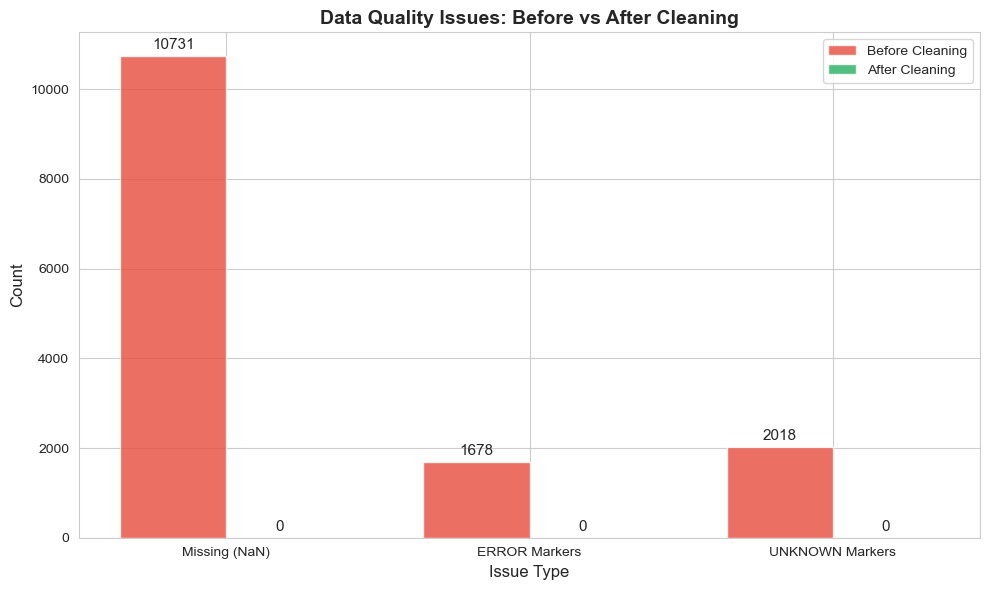


Total issues before: 14427
Total issues after: 0
Issues resolved: 14427 (100.0% improvement)


In [43]:
# Calculate issues for before/after comparison
# Only check the original columns for ERROR/UNKNOWN markers 
original_columns = ['Transaction ID', 'Item', 'Quantity', 'Price Per Unit', 'Total Spent',
                    'Payment Method', 'Location', 'Transaction Date']

issues_before = {
    'Missing (NaN)': df_original.isnull().sum().sum(),
    'ERROR Markers': sum((df_original[col].astype(str).str.upper() == 'ERROR').sum() 
                 for col in df_original.columns),
    'UNKNOWN Markers': sum((df_original[col].astype(str).str.upper() == 'UNKNOWN').sum() 
                   for col in df_original.columns),
}

# After cleaning: only count markers in original columns to avoid counting
# derived values like Contact_Type = 'Unknown' which is a valid category
issues_after = {
    'Missing (NaN)': df_clean[original_columns].isnull().sum().sum(),
    'ERROR Markers': sum((df_clean[col].astype(str).str.upper() == 'ERROR').sum() 
                 for col in original_columns),
    'UNKNOWN Markers': sum((df_clean[col].astype(str).str.upper() == 'UNKNOWN').sum() 
                   for col in original_columns),
}

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))

categories = list(issues_before.keys())
before_values = list(issues_before.values())
after_values = list(issues_after.values())

x = np.arange(len(categories))
width = 0.35

bars1 = ax.bar(x - width/2, before_values, width, label='Before Cleaning', color='#e74c3c', alpha=0.8)
bars2 = ax.bar(x + width/2, after_values, width, label='After Cleaning', color='#27ae60', alpha=0.8)

ax.set_xlabel('Issue Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Data Quality Issues: Before vs After Cleaning', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=11)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

total_before = sum(issues_before.values())
total_after = sum(issues_after.values())
print(f"\nTotal issues before: {total_before}")
print(f"Total issues after: {total_after}")
print(f"Issues resolved: {total_before - total_after} ({(total_before - total_after)/total_before*100:.1f}% improvement)")

### 5.3 Visualization: New Column Cleaning Results

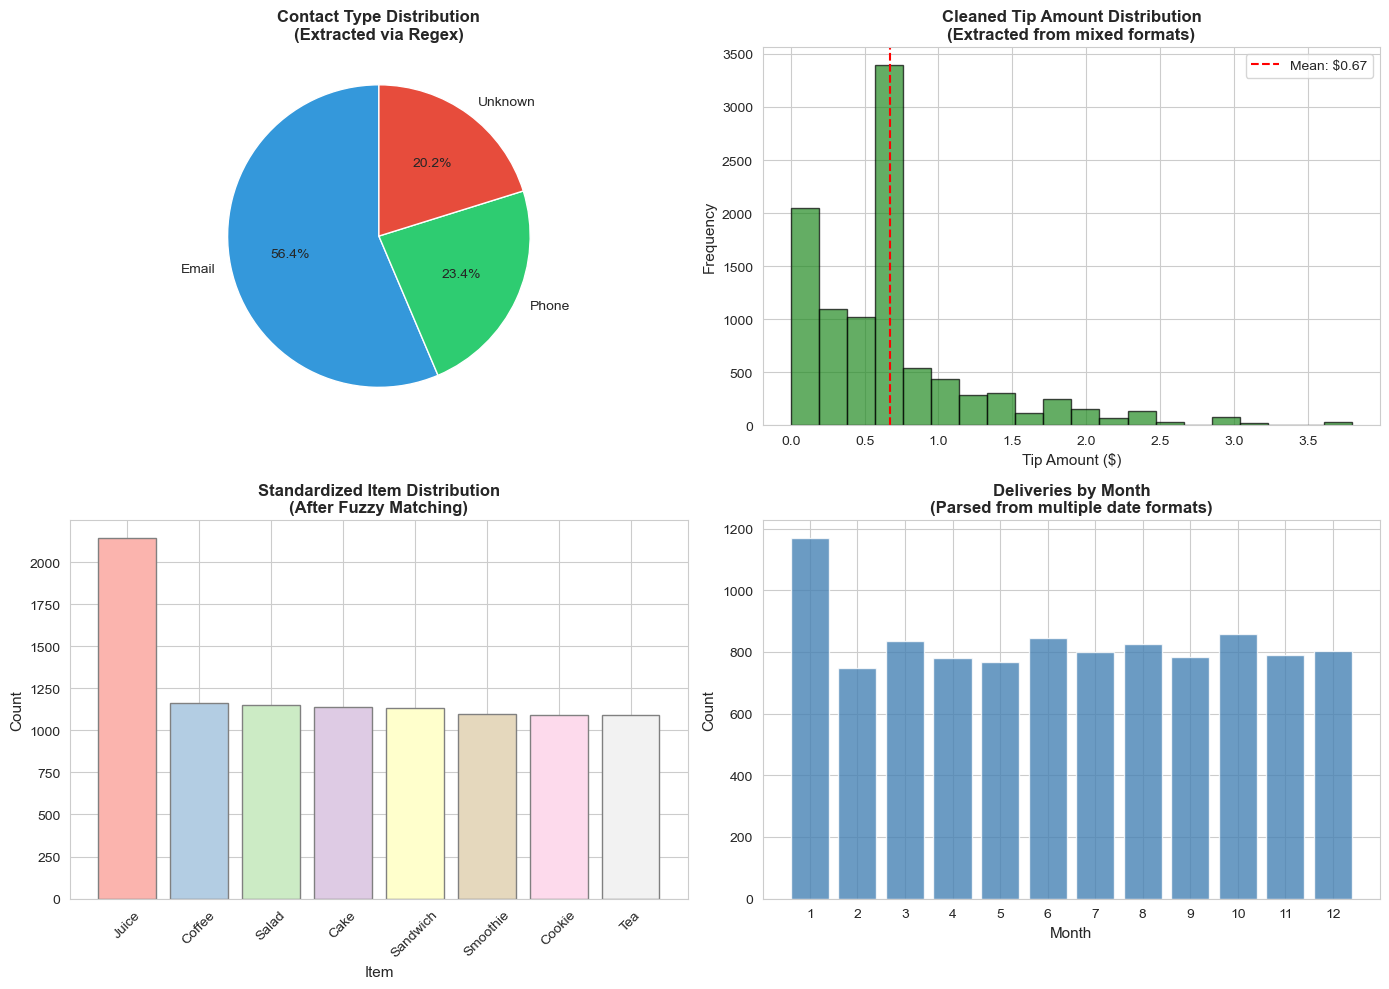

In [44]:
# Visualize the results of cleaning the new columns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Contact Type Distribution
contact_counts = df_clean['Contact_Type'].value_counts()
colors1 = ['#3498db', '#2ecc71', '#e74c3c']
axes[0, 0].pie(contact_counts.values, labels=contact_counts.index, autopct='%1.1f%%',
               colors=colors1, startangle=90)
axes[0, 0].set_title('Contact Type Distribution\n(Extracted via Regex)', fontsize=12, fontweight='bold')

# 2. Tip Amount Distribution (cleaned)
axes[0, 1].hist(df_clean['Tip_Cleaned'], bins=20, color='forestgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Tip Amount ($)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Cleaned Tip Amount Distribution\n(Extracted from mixed formats)', fontsize=12, fontweight='bold')
axes[0, 1].axvline(df_clean['Tip_Cleaned'].mean(), color='red', linestyle='--', 
                   label=f'Mean: ${df_clean["Tip_Cleaned"].mean():.2f}')
axes[0, 1].legend()

# 3. Item Standardization Results
item_counts = df_clean['Item'].value_counts()
colors3 = plt.cm.Pastel1(np.linspace(0, 1, len(item_counts)))
bars = axes[1, 0].bar(item_counts.index, item_counts.values, color=colors3, edgecolor='gray')
axes[1, 0].set_xlabel('Item', fontsize=11)
axes[1, 0].set_ylabel('Count', fontsize=11)
axes[1, 0].set_title('Standardized Item Distribution\n(After Fuzzy Matching)', fontsize=12, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Delivery Date - Monthly Distribution
monthly_deliveries = df_clean.groupby(df_clean['Delivery_Date_Parsed'].dt.month).size()
axes[1, 1].bar(monthly_deliveries.index, monthly_deliveries.values, color='steelblue', alpha=0.8)
axes[1, 1].set_xlabel('Month', fontsize=11)
axes[1, 1].set_ylabel('Count', fontsize=11)
axes[1, 1].set_title('Deliveries by Month\n(Parsed from multiple date formats)', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

### 5.4 Visualization: Data Completeness Comparison

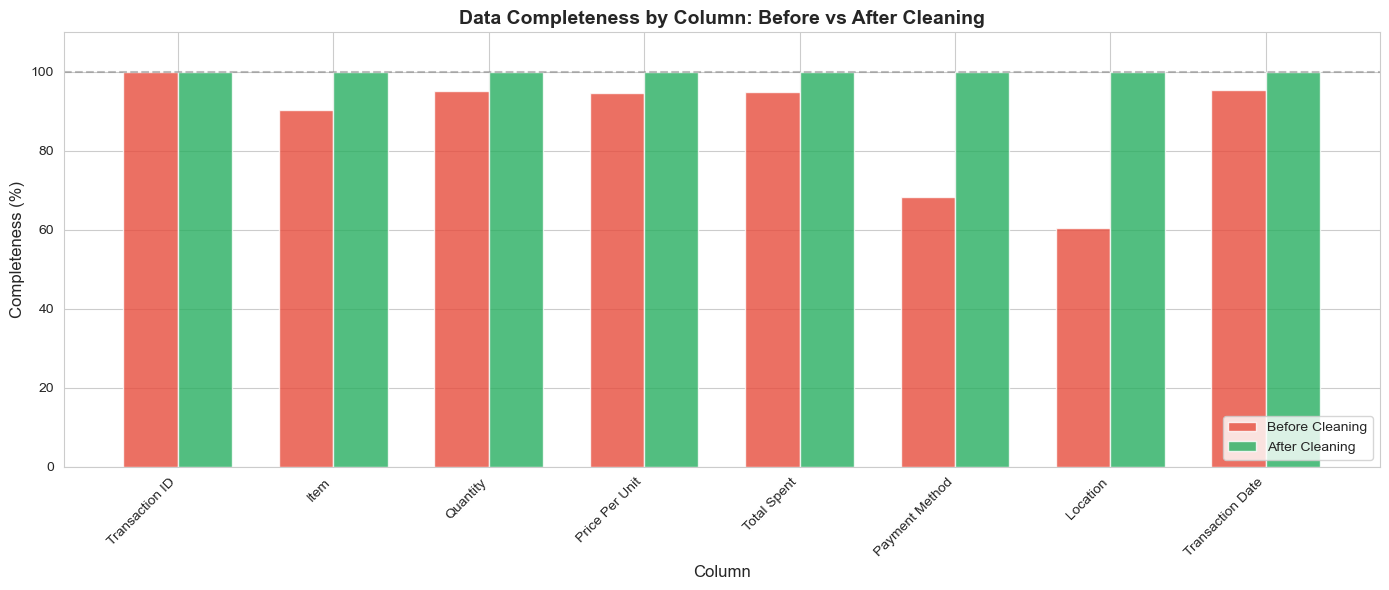


Completeness Improvement:
------------------------------------------------------------
Transaction ID      : 100.0% → 100.0% (+0.0%)
Item                :  90.3% → 100.0% (+9.7%)
Quantity            :  95.2% → 100.0% (+4.8%)
Price Per Unit      :  94.7% → 100.0% (+5.3%)
Total Spent         :  95.0% → 100.0% (+5.0%)
Payment Method      :  68.2% → 100.0% (+31.8%)
Location            :  60.4% → 100.0% (+39.6%)
Transaction Date    :  95.4% → 100.0% (+4.6%)


In [52]:
# Calculate completeness for core columns
core_cols = ['Transaction ID', 'Item', 'Quantity', 'Price Per Unit', 'Total Spent',
             'Payment Method', 'Location', 'Transaction Date']

completeness_before = {}
for col in core_cols:
    total = len(df_original)
    invalid = (df_original[col].isna().sum() + 
               (df_original[col].astype(str).str.upper() == 'ERROR').sum() +
               (df_original[col].astype(str).str.upper() == 'UNKNOWN').sum() +
               (df_original[col].astype(str).str.strip() == '').sum())
    completeness_before[col] = ((total - invalid) / total) * 100

completeness_after = {}
for col in core_cols:
    total = len(df_clean)
    invalid = df_clean[col].isna().sum()
    completeness_after[col] = ((total - invalid) / total) * 100

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(core_cols))
width = 0.35

bars1 = ax.bar(x - width/2, list(completeness_before.values()), width, 
               label='Before Cleaning', color='#e74c3c', alpha=0.8)
bars2 = ax.bar(x + width/2, list(completeness_after.values()), width, 
               label='After Cleaning', color='#27ae60', alpha=0.8)

ax.set_xlabel('Column', fontsize=12)
ax.set_ylabel('Completeness (%)', fontsize=12)
ax.set_title('Data Completeness by Column: Before vs After Cleaning', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(core_cols, rotation=45, ha='right')
ax.legend(loc='lower right')
ax.set_ylim(0, 110)
ax.axhline(y=100, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\nCompleteness Improvement:")
print("-" * 60)
for col in core_cols:
    improvement = completeness_after[col] - completeness_before[col]
    print(f"{col:20s}: {completeness_before[col]:5.1f}% → {completeness_after[col]:5.1f}% (+{improvement:.1f}%)")

### 5.5 Final Cleaned Dataset Summary

In [46]:
print("=" * 70)
print("CLEANED DATASET SUMMARY")
print("=" * 70)

print("\nFirst 10 rows:")
df_clean.head(10)

CLEANED DATASET SUMMARY

First 10 rows:


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,Contact_Email,Contact_Phone,Contact_Type,Delivery_Date_Parsed,Tip_Cleaned,Year,Month,Month_Name,Day,Day_of_Week,Quarter,Revenue_Category
0,TXN_1961373,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08,alexkhan@example.com,0000000000,Email,2023-09-08 08:10:00,0.490000,2023,9,September,8,Friday,3,Low
1,TXN_4977031,Cake,4.0,3.0,12.0,Cash,In-Store,2023-05-16,not_provided@unknown.com,0000000000,Unknown,2023-05-16 11:30:00,0.010000,2023,5,May,16,Tuesday,2,High
2,TXN_4271903,Cookie,4.0,1.0,4.0,Credit Card,In-Store,2023-07-19,alexkim.84@coffeeclub.net,0000000000,Email,2023-07-20 00:00:00,0.670000,2023,7,July,19,Wednesday,3,Low
3,TXN_7034554,Salad,2.0,5.0,10.0,Digital Wallet,Takeaway,2023-04-27,not_provided@unknown.com,+19146326574,Phone,2023-04-27 14:05:00,1.000000,2023,4,April,27,Thursday,2,Medium
4,TXN_3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-Store,2023-06-11,taylormartin100@iu.org,0000000000,Email,2023-06-11 00:00:00,0.650000,2023,6,June,11,Sunday,2,Low
5,TXN_2602893,Smoothie,5.0,4.0,20.0,Credit Card,Takeaway,2023-03-31,cameron.jones.25@example.com,0000000000,Email,2023-03-31 07:05:00,1.000000,2023,3,March,31,Friday,1,Premium
6,TXN_4433211,Juice,3.0,3.0,9.0,Digital Wallet,Takeaway,2023-10-06,not_provided@unknown.com,+15894848428,Phone,2023-10-07 14:30:00,0.672994,2023,10,October,6,Friday,4,Medium
7,TXN_6699534,Sandwich,4.0,4.0,16.0,Cash,Takeaway,2023-10-28,not_provided@unknown.com,9188992169,Phone,2023-10-28 00:00:00,0.672994,2023,10,October,28,Saturday,4,Premium
8,TXN_4717867,Juice,5.0,3.0,15.0,Digital Wallet,Takeaway,2023-07-28,charliemartin.82@mail.com,0000000000,Email,2023-07-28 00:00:00,0.750000,2023,7,July,28,Friday,3,High
9,TXN_2064365,Sandwich,5.0,4.0,20.0,Digital Wallet,In-Store,2023-12-31,avery_garcia.73@mail.com,0000000000,Email,2023-12-31 00:00:00,2.410000,2023,12,December,31,Sunday,4,Premium


In [47]:
print("\nDataset Info:")
df_clean.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Transaction ID        10000 non-null  object        
 1   Item                  10000 non-null  object        
 2   Quantity              10000 non-null  float64       
 3   Price Per Unit        10000 non-null  float64       
 4   Total Spent           10000 non-null  float64       
 5   Payment Method        10000 non-null  object        
 6   Location              10000 non-null  object        
 7   Transaction Date      10000 non-null  datetime64[ns]
 8   Contact_Email         10000 non-null  object        
 9   Contact_Phone         10000 non-null  object        
 10  Contact_Type          10000 non-null  object        
 11  Delivery_Date_Parsed  10000 non-null  datetime64[ns]
 12  Tip_Cleaned           10000 non-null  float64       
 13  Ye

In [48]:
print("\nStatistical Summary:")
df_clean.describe()


Statistical Summary:


,Quantity,Price Per Unit,Total Spent,Transaction Date,Delivery_Date_Parsed,Tip_Cleaned,Year,Month,Day,Quarter
count,10000.000000,10000.000000,10000.000000,10000,10000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000
mean,3.027100,2.947950,8.935650,2023-07-02 00:30:31.680000256,2023-06-26 02:58:36,0.672994,2023.0,6.525900,15.743900,2.508500
min,1.000000,1.000000,1.000000,2023-01-01 00:00:00,2023-01-01 00:00:00,0.000000,2023.0,1.000000,1.000000,1.000000
25%,2.000000,2.000000,4.000000,2023-04-01 00:00:00,2023-03-23 00:00:00,0.250000,2023.0,4.000000,8.000000,2.000000
50%,3.000000,3.000000,8.000000,2023-07-02 00:00:00,2023-06-26 11:35:00,0.672994,2023.0,7.000000,16.000000,3.000000
75%,4.000000,4.000000,12.000000,2023-10-02 00:00:00,2023-09-28 19:18:45,0.750000,2023.0,10.000000,23.000000,4.000000
max,5.000000,5.000000,25.000000,2023-12-31 00:00:00,2024-01-01 12:45:00,3.800000,2023.0,12.000000,31.000000,4.000000
std,1.384614,1.277196,5.913145,NaN,NaN,0.600215,0.0,3.452089,8.765968,1.121452


### 5.6 Save Cleaned Dataset

In [49]:
# Save the cleaned dataset
output_path = 'clean_cafe_sales.csv'
df_clean.to_csv(output_path, index=False)

print(f"Cleaned dataset saved to: {output_path}")
print(f"\nFinal dataset shape: {df_clean.shape}")

Cleaned dataset saved to: clean_cafe_sales.csv

Final dataset shape: (10000, 20)


## 6. Summary and Conclusions

### 6.1 Data Wrangling Summary

In [50]:
print("=" * 70)
print("DATA WRANGLING SUMMARY")
print("=" * 70)

summary = f"""
1. INITIAL STATE:
   - Dataset size: {df_original.shape[0]} rows × {df_original.shape[1]} columns
   - Multiple data quality issues in original columns
   - Four new "dirty" columns requiring advanced cleaning

2. CLEANING TECHNIQUES APPLIED:

   a) REGULAR EXPRESSION EXTRACTION (Customer Contact):
      - Extracted emails using pattern: [a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{{2,}}
      - Extracted phones using pattern for various formats
      - Created separate Contact_Email and Contact_Phone columns

   b) PATTERN-BASED DATE PARSING (Delivery ETA):
      - Handled 10+ different date formats
      - Removed prefixes like 'ETA:'
      - Handled invalid dates gracefully

   c) FUZZY STRING MATCHING (Item Reported):
      - Used difflib.SequenceMatcher for similarity scoring
      - Created known mappings for common variations
      - Matched misspelled items to standard menu (60%+ threshold)

   d) STRING CLEANING AND EXTRACTION (Tip Amount):
      - Removed currency symbols (€, £, $)
      - Handled European decimal format (comma → period)
      - Extracted numeric values from various formats

   e) IMPUTATION WITH fillna():
      - Mode imputation for categorical columns
      - Median imputation for numeric columns
      - Mean imputation for tip amounts
      - Forward/backward fill for dates
      - Default values for contact information

3. FINAL STATE:
   - Dataset size: {df_clean.shape[0]} rows × {df_clean.shape[1]} columns
   - All missing values handled
   - Data types corrected
   - New derived features added

4. TIDY DATA PRINCIPLES APPLIED:
   ✓ Each variable forms a column
   ✓ Each observation forms a row
   ✓ Each type of observational unit forms a table
   ✓ Data is ready for analysis
"""

print(summary)
print("=" * 70)

DATA WRANGLING SUMMARY

1. INITIAL STATE:
   - Dataset size: 10000 rows × 12 columns
   - Multiple data quality issues in original columns
   - Four new "dirty" columns requiring advanced cleaning

2. CLEANING TECHNIQUES APPLIED:

   a) REGULAR EXPRESSION EXTRACTION (Customer Contact):
      - Extracted emails using pattern: [a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}
      - Extracted phones using pattern for various formats
      - Created separate Contact_Email and Contact_Phone columns

   b) PATTERN-BASED DATE PARSING (Delivery ETA):
      - Handled 10+ different date formats
      - Removed prefixes like 'ETA:'
      - Handled invalid dates gracefully

   c) FUZZY STRING MATCHING (Item Reported):
      - Used difflib.SequenceMatcher for similarity scoring
      - Created known mappings for common variations
      - Matched misspelled items to standard menu (60%+ threshold)

   d) STRING CLEANING AND EXTRACTION (Tip Amount):
      - Removed currency symbols (€, £, $)
      - Ha

### 6.2 Key Takeaways

**Data Wrangling Techniques Used:**

1. **Regular Expressions**:
   - Essential for parsing semi-structured text data
   - Email pattern: `[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}`
   - Phone pattern: handles various formats with optional country codes

2. **Fuzzy String Matching**:
   - Uses `difflib.SequenceMatcher` for similarity scoring
   - Threshold-based matching (60%+ similarity)
   - Combines with known mappings for better accuracy

3. **Multi-format Date Parsing**:
   - Try multiple date formats sequentially
   - Handle prefixes and invalid dates gracefully
   - Convert to standard datetime format

4. **Currency Normalization**:
   - Remove symbols and currency codes
   - Handle European decimal format
   - Extract numeric values with regex

**Data Quality Dimensions Addressed:**

| Dimension | Technique Used |
|-----------|---------------|
| Accuracy | Fuzzy matching, calculation validation |
| Completeness | fillna() with appropriate strategies |
| Consistency | Standardization, data type conversion |
| Timeliness | Multi-format date parsing |

**Benefits of Advanced Data Cleaning:**

- **Structured from Unstructured**: Contact info now in separate, queryable columns
- **Standardized Vocabulary**: Fuzzy matching ensures consistent item names
- **Normalized Formats**: All dates and currencies in standard format
- **Analysis-Ready**: Data can now be used for business intelligence

**Potential Drawbacks:**

- **False Matches**: Fuzzy matching may incorrectly match some items
- **Information Loss**: Percentage tips converted to NaN
- **Assumptions**: Default values may not reflect reality

This notebook demonstrates that real-world data often requires sophisticated cleaning techniques beyond simple missing value handling. The investment in proper data wrangling is essential for reliable analysis results.

---

## References

- Dasu, T., & Johnson, T. (2003). *Exploratory data mining and data cleaning*. John Wiley & Sons.
- Kazil, J., & Jarmul, K. (2016). *Data Wrangling with Python*. O'Reilly Media.
- Loshin, D. (2011). *The Practitioner's Guide to Data Quality Improvement*. Morgan Kaufmann.
- Wang, R. Y., & Strong, D. M. (1996). Beyond accuracy: What data quality means to data consumers. *Journal of Management Information Systems*, 12(4), 5-33.
- Wickham, H. (2014). Tidy data. *Journal of Statistical Software*, 59(10), 1-23.
- Course Book: Data Quality and Data Wrangling (DLBDSDQDW01), IU International University of Applied Sciences.